In [85]:
#libraries
import numpy as np
from PIL import Image, ImageFilter
from scipy import ndimage
import matplotlib.pyplot as plt
import cv2
import part1 #Gabby, smooth_image and gradient_map
#import part2.py #Chris, suppress_nommaxima, double_threshold


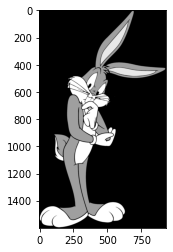

In [86]:
#intake photo
photopath = "./images/stage2.png"
if not ("_greyscale" in photopath):
    newphotopath = photopath[:-4]+"_greyscale"+photopath[-4:]
    init_img = Image.open(photopath).convert('L')
    init_img.save(newphotopath)
    img = cv2.imread(newphotopath) #This is the initial greyscaled image
else:
    img = cv2.imread(photopath)
    
plt.imshow(img)
plt.show()

In [87]:
img.shape

(1600, 930, 3)

In [88]:
def smooth_image(photo):
    blurred_photo=cv2.GaussianBlur(photo,(5,5),cv2.BORDER_DEFAULT)
    return blurred_photo

In [89]:
#compute the gradient magnitude and output the gradient intensity picture
def gradient_magnitude(blurred_photo):
# Below code converts image gradient in both x and y direction
    lap = cv2.Laplacian(blurred_photo,cv2.CV_64F,ksize=3) 
    lap = np.uint8(np.absolute(lap))

# Below code convert image gradient in x direction
    sobelx= cv2.Sobel(np.float32(blurred_photo),ddepth = cv2.CV_64F, dx=1,dy=0,ksize = 3)
    #sobelx= np.uint8(np.absolute(sobelx))
    

# Below code convert image gradient in y direction
    sobely= cv2.Sobel(np.float32(blurred_photo),ddepth = cv2.CV_64F, dx=0,dy=1,ksize = 3)
    print(type(sobely))
    #sobely = np.uint8(np.absolute(sobely))
    results = [lap,sobelx,sobely]
    images =["Gradient Image","Gradient In X direction","Gradient In Y direction"]

    for i in range(3):
        Gradient_Image=plt.figure(1)
        plt.title(results[i])
        plt.subplot(1,3,i+1)
        plt.imshow(results[i],"plasma")
        plt.xticks([])
        plt.yticks([])
        plt.show()
    return Gradient_Image,results

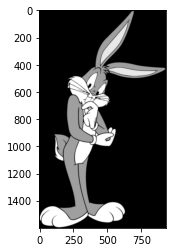

In [90]:
smoothed = smooth_image(img)

plt.imshow(smoothed)
plt.show()

<class 'numpy.ndarray'>


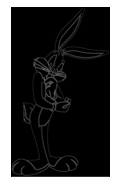

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


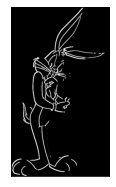

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


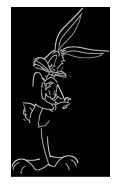

In [91]:
img_gm, results = gradient_magnitude(smoothed)
gm = [results[1],results[2]]

In [92]:
def suppress_nonmaxima(img, sobel_deriv):
    """
    Function definition for nonmaxima suppression for use in Canny edge detection
    Arguments are 
    1. img, a greyscaled, blurred input image
    2. sobel_deriv, a data structure containing the vectors of the Sobel gradient magnitude of the image. 0th index should be x, 1st index should be y
    """
    h,w,unused= img.shape    #Define dimensions of image for iteration
    
    #Convert sobel x/y to magnitude/direction
    mag, theta = cv2.cartToPolar(sobel_deriv[0],sobel_deriv[1],angleInDegrees=True)
    #Now loop through the full image
    for i in range(w):
        for j in range(h):
            ang = theta[j,i][1]
            ang = abs(ang-180) if abs(ang)>180 else abs(ang)
            
            
            #nearest-neighbor selection      
        
            if ang <= 22.5:
                n1x ,n1y = i-1,j
                n2x,n2y = i+1,j
            elif 22.5+45 >= ang > 22.5:
                n1x,n1y = i-1,j-1
                n2x,n2y = i+1,j+1
            elif 22.5+90 >= ang > 22.5+45:
                n1x,n1y = i,j-1
                n2x,n2y = i,j+1
            elif 22.5+135 >= ang > 22.5+90:
                n1x,n1y = i-1,j+1
                n2x,n2y = i+1,j-1
            elif 22.5+180 >= ang > 22.5+135:
                n1x,n1y = i-1,j
                n2x,n2y = i+1,j
                
            #NMS step
            #Checks if pixel is in image, 
            #then only allows strongest relations through
            
            if w>n1x >= 0 and h>n1y>= 0:
                if mag[j,i][1]<mag[n1y,n1x][1]:
                    mag[j,i] = 0
                    continue
            if w > n2x >= 0 and h > n2y >= 0:
                if mag[j,i][1]< mag[n2y,n2x][1]:
                    mag[j,i][1] = 0 
    return mag

def double_threshold(mag,img,thresh = [None,None]):
    """
    Function implementing double thresholding step of Canny edge detection.
    Magnitudes lower than the weak thresh are removed from the image, and
    magnitudes greater than the strong thresh are marked in the 'id' array that can be used later for hysteresis edge tracking.
    
    Takes three arguments: 
    1. mag, an array of nonmaxima-suppressed gradient magnitudes
    2. img, the image under analysis (used only for determining size paremeters, so the blurred image is also able to be used)
    3. thresh (an array value with the first being a weak threshold value, and the second a stronger threshold value
    
    Returns the final filtered array of magnitudes for basic Canny edge detection
    """
    #If thresh values undefined, set thresh values
    mmax = np.max(mag)
    if not thresh[0]:thresh[0] = mmax*0.1
    if not thresh[1]:thresh[1] = mmax*0.5
        
    #create id vector
    ids = np.zeros_like(img)
    h,w,unused = img.shape
    
    #loop through image again pixel-by-pixel and apply double thresholding to magnitude array
    for j in range(w):
        for i in range(h):
            gmag = mag[i,j][1]
            if gmag < thresh[0]:
                mag[i,j] = 0
            elif thresh[1]> gmag >= thresh[0]:
                ids[i,j] = 1
            else:
                ids[i,j] = 2
    return mag
          



In [103]:
mag = suppress_nonmaxima(img,gm)
fnl = double_threshold(mag,img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


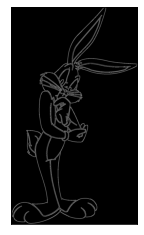

In [102]:
fig = plt.imshow(fnl)
fig.axes.get_yaxis().set_visible(False)
fig.axes.get_xaxis().set_visible(False)